In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from mordred import Calculator, descriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
import matplotlib.pyplot as plt


from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [210]:
df = pd.read_csv("pIC50.csv")
df

,cid,smiles,bioactivity,type,value (nM),pIC50
0,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,8300.0,5.080922
1,127024762,C[C@@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2C...,Active,IC50,1570.0,5.804100
2,127024157,C[C@@H]1C[C@H]1Nc1nc2cnncc2nc1N1CCC([C@@H](F)c...,Active,IC50,145.0,6.838632
3,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,6600.0,5.180456
4,155525744,C[C@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2Cl...,Active,IC50,1570.0,5.804100
...,...,...,...,...,...,...
435,118159306,COc1ccc(OC2CCN(c3nc4c(nc3NC3CC3)CCN(C)C4)CC2)c...,Inactive,IC50,145000.0,3.838632
436,118159408,COCC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F...,Inactive,IC50,79500.0,4.099633
437,118159205,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,Inactive,IC50,49300.0,4.307153
438,118180378,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,Inactive,IC50,57200.0,4.242604


In [211]:
#from sklearn.datasets import load_iris

In [212]:
#iris = load_iris()
#
#iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
#iris_df.head()
#iris_df.shape
#

In [213]:
#iris_X = np.array(iris_df)
#iris_X

In [214]:
    #iris_df['target'] = iris.target
    #iris_y = np.array(iris_df['target'])
    #iris_y.shape

<Figure size 2000x2000 with 0 Axes>

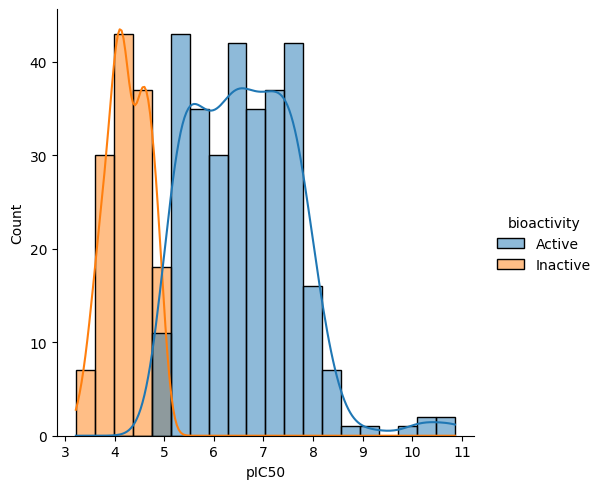

In [215]:
plt.figure(figsize=(20, 20))

sns.displot(df, bins=20, x='pIC50', hue='bioactivity', kde=True)
plt.show()

In [216]:
df = df[["cid", "smiles", "pIC50"]]
df

,cid,smiles,pIC50
0,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,5.080922
1,127024762,C[C@@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2C...,5.804100
2,127024157,C[C@@H]1C[C@H]1Nc1nc2cnncc2nc1N1CCC([C@@H](F)c...,6.838632
3,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,5.180456
4,155525744,C[C@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2Cl...,5.804100
...,...,...,...
435,118159306,COc1ccc(OC2CCN(c3nc4c(nc3NC3CC3)CCN(C)C4)CC2)c...,3.838632
436,118159408,COCC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F...,4.099633
437,118159205,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.307153
438,118180378,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.242604


In [217]:
df["activity_label"] = np.zeros(len(df))

df.loc[df[df.pIC50 >= 5].index, "activity_label"] = 1.0

print("Number of active molecules:", int(df.activity_label.sum()))
print("Number of inactive molecules:", len(df) - int(df.activity_label.sum()))

df

Number of active molecules: 305
Number of inactive molecules: 135


C:\Users\supak\AppData\Local\Temp\ipykernel_9948\188660524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["activity_label"] = np.zeros(len(df))


,cid,smiles,pIC50,activity_label
0,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,5.080922,1.0
1,127024762,C[C@@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2C...,5.804100,1.0
2,127024157,C[C@@H]1C[C@H]1Nc1nc2cnncc2nc1N1CCC([C@@H](F)c...,6.838632,1.0
3,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,5.180456,1.0
4,155525744,C[C@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2Cl...,5.804100,1.0
...,...,...,...,...
435,118159306,COc1ccc(OC2CCN(c3nc4c(nc3NC3CC3)CCN(C)C4)CC2)c...,3.838632,0.0
436,118159408,COCC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F...,4.099633,0.0
437,118159205,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.307153,0.0
438,118180378,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.242604,0.0


Create Fingerprint

In [218]:
def fingerprints(smiles, method="maccs", n_bits=2048):

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan4":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [219]:
compound_df = df.copy()

compound_df["fp"] = compound_df["smiles"].apply(fingerprints)
compound_df

,cid,smiles,pIC50,activity_label,fp
0,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,5.080922,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,127024762,C[C@@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2C...,5.804100,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,127024157,C[C@@H]1C[C@H]1Nc1nc2cnncc2nc1N1CCC([C@@H](F)c...,6.838632,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,5.180456,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,155525744,C[C@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2Cl...,5.804100,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
435,118159306,COc1ccc(OC2CCN(c3nc4c(nc3NC3CC3)CCN(C)C4)CC2)c...,3.838632,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
436,118159408,COCC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F...,4.099633,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
437,118159205,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.307153,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
438,118180378,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.242604,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


ML Functions

In [261]:
#Plot Data
def plot_curve_functions(models, test_x, test_y):
    
    fig, ax = plt.subplots()
    
    
    #Loop iterates model list
    for model in models:
        
        #Select model
        ml_model = model["model"]
        
        #Predict test probability
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        
        #Predict class on test set
        test_pred = ml_model.predict(test_x)
        
        #Compute False/True postitive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        
        #Calculate AUC
        auc = roc_auc_score(test_y, test_prob)
        
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.5f}"))
    
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

    #if save_png:
        #fig.savefig(dpi=300, bbox_inches="tight", transparent=True)
    #return fig

In [262]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    
    #Predict probability on test set
    test_prob = ml_model.predict_proba(test_x)[: ,1]
    
    #Predict class on test set
    test_pred = ml_model.predict(test_x)
    
    #Performance of test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
    spec = recall_score(test_y, test_pred, pos_label=0)#, average='macro)
    auc = roc_auc_score(test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
    cm = confusion_matrix(test_y, test_pred)
    
    if verbose:
        print(f"Accuracy: {accuracy:.5f}")
        print(f"Sensitivity: {sens:.5f}")
        print(f"Specificity: {spec:.5f}")
        print(f"AUC: {auc:.5f}")
        print(f"Confusion Matrix: {cm}")

    return accuracy, sens, spec, auc, cm

In [263]:
def model_training_and_validation(ml_model, name, splits, verbose=True):

    train_x, test_x, train_y, test_y = splits

    #Fit model
    ml_model.fit(train_x, train_y)

    #Calculate performance results
    accuracy, sens, spec, auc, cm = model_performance(ml_model, test_x, test_y, verbose)
    
    sns.heatmap(cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    
    return accuracy, sens, spec, auc, cm

Split Data

In [264]:
fp_to_model = compound_df.fp.tolist()
label_to_model = compound_df.activity_label.tolist()


(static_train_x, 
 static_test_x, 
 static_train_y,
 static_test_y) = train_test_split(fp_to_model, label_to_model, 
                                   test_size=0.2)

splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))


Training data size: 352
Test data size: 88


Random Forest

In [265]:
param = {
    "n_estimators": 40,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

Accuracy: 0.96591
Sensitivity: 0.95385
Specificity: 1.00000
AUC: 0.97726
Confusion Matrix: [[23  0]
 [ 3 62]]


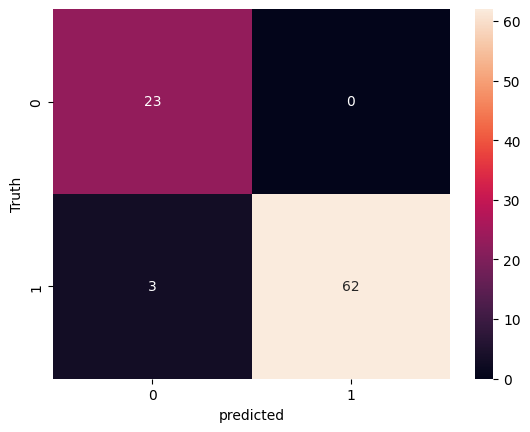

In [266]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

In [267]:
#feature_iris = pd.Series(model_RF.feature_importances_, index=compound_df.fp).sort_values(ascending=False)
#feature_iris

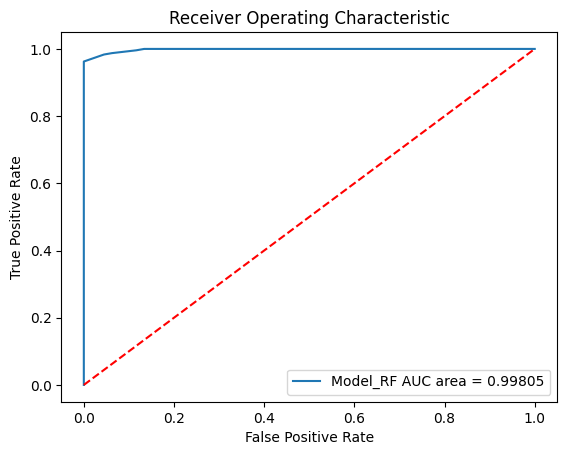

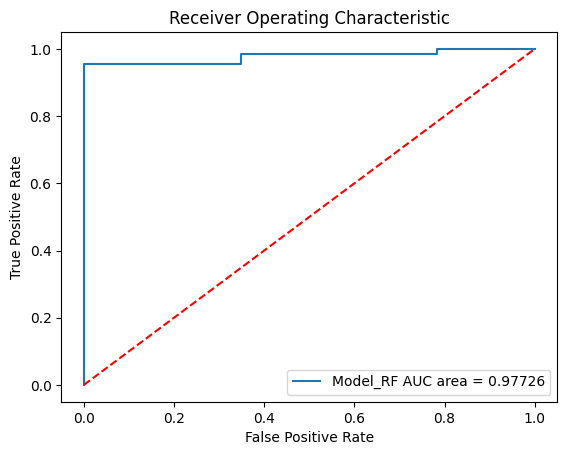

In [268]:
models = [{"label": "Model_RF", "model": model_RF}]

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

SVM

Accuracy: 0.93182
Sensitivity: 0.93846
Specificity: 0.91304
AUC: 0.97659
Confusion Matrix: [[21  2]
 [ 4 61]]


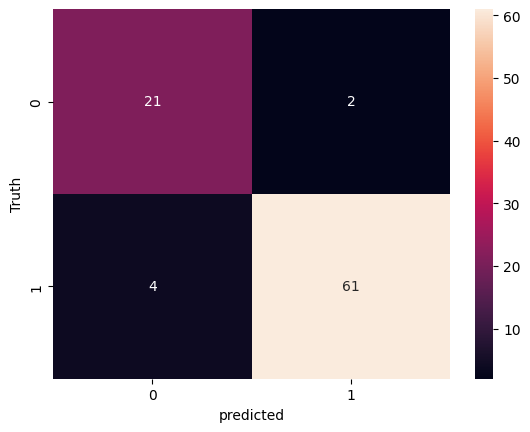

In [269]:
model_SVM = svm.SVC(kernel="linear", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

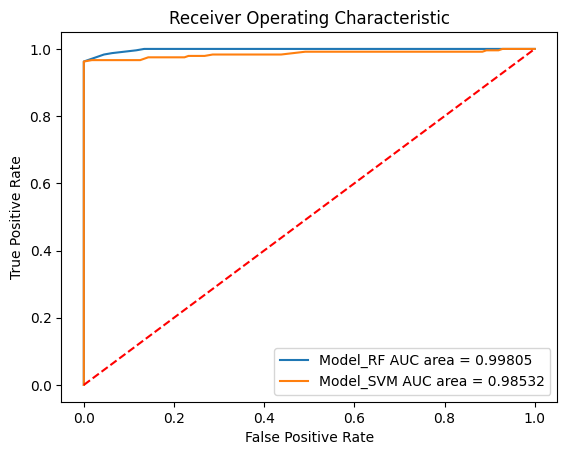

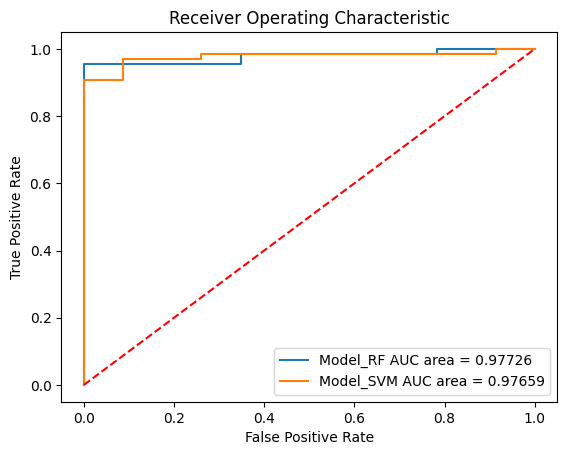

In [270]:
models.append({"label": "Model_SVM", "model": model_SVM})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

ANN

Accuracy: 0.92045
Sensitivity: 0.92308
Specificity: 0.91304
AUC: 0.96187
Confusion Matrix: [[21  2]
 [ 5 60]]


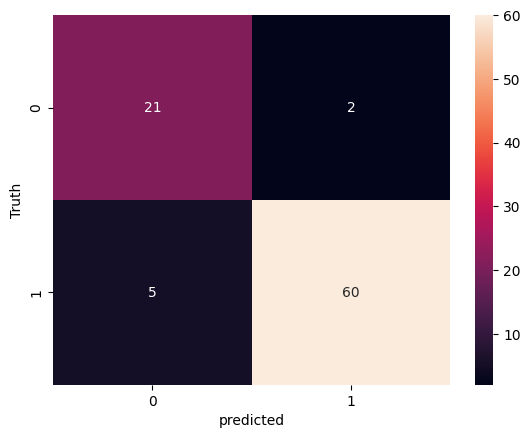

In [271]:
#Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(3, ), activation='identity',
                          solver='lbfgs', alpha=0.0001, max_iter=400)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

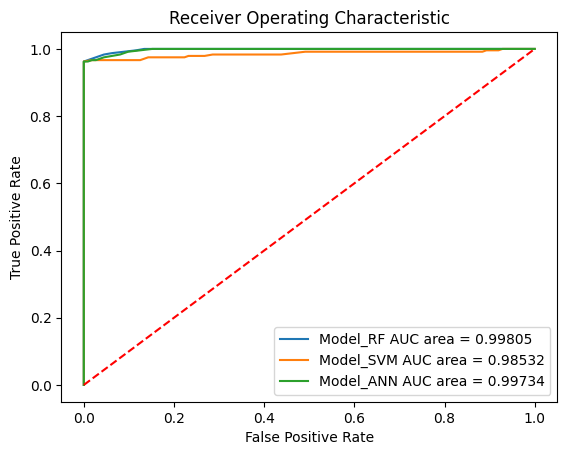

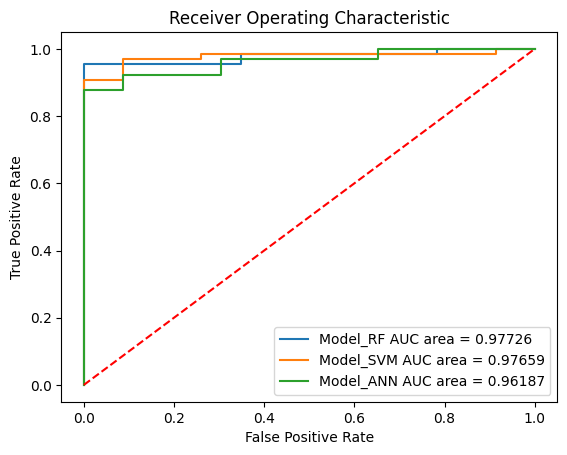

In [272]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

Classification Using Molecular Features

In [273]:
df

,cid,smiles,pIC50,activity_label
0,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,5.080922,1.0
1,127024762,C[C@@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2C...,5.804100,1.0
2,127024157,C[C@@H]1C[C@H]1Nc1nc2cnncc2nc1N1CCC([C@@H](F)c...,6.838632,1.0
3,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,5.180456,1.0
4,155525744,C[C@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2Cl...,5.804100,1.0
...,...,...,...,...
435,118159306,COc1ccc(OC2CCN(c3nc4c(nc3NC3CC3)CCN(C)C4)CC2)c...,3.838632,0.0
436,118159408,COCC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F...,4.099633,0.0
437,118159205,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.307153,0.0
438,118180378,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,4.242604,0.0


In [274]:
smile = [Chem.MolFromSmiles(i) for i in df.smiles]
mol = [m for m in smile]
len(mol)

440

In [275]:
descriptors = [Descriptors.CalcMolDescriptors(i) for i in mol]
rdkit_gpr6 = pd.DataFrame(descriptors)
rdkit_gpr6

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
1,10.578704,10.578704,0.029880,-5.083333,0.399686,560.404,534.196,559.136480,200,0,...,0,0,0,0,0,0,0,0,0,0
2,15.017304,15.017304,0.075002,-5.083333,0.430629,542.484,518.292,542.186493,204,0,...,0,0,0,0,0,0,0,0,0,0
3,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
4,10.578704,10.578704,0.029880,-5.083333,0.399686,560.404,534.196,559.136480,200,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,14.260008,14.260008,0.017865,-0.386692,0.759391,427.524,397.284,427.238353,166,0,...,0,0,0,0,0,0,0,0,0,0
436,13.948082,13.948082,0.015251,-2.562425,0.562032,497.493,470.277,497.205003,190,0,...,0,0,0,0,0,0,0,0,0,0
437,13.979032,13.979032,0.065919,-3.292755,0.661772,493.580,464.348,493.195917,184,0,...,0,1,0,0,0,0,0,0,0,0
438,13.907236,13.907236,0.024868,-3.421934,0.581743,503.522,478.322,503.161424,186,0,...,0,1,0,0,0,0,0,0,0,0


In [276]:
rdkit_gpr6.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.0,...,440.000000,440.000000,440.000000,440.0,440.0,440.0,440.0,440.000000,440.000000,440.000000
mean,13.348780,13.348780,0.148058,-2.732229,0.565677,477.933855,453.570036,477.451584,176.559091,0.0,...,0.006818,0.063636,0.018182,0.0,0.0,0.0,0.0,0.029545,0.020455,0.050000
std,1.562345,1.562345,0.158185,2.119561,0.145279,89.209615,84.945946,89.098195,36.154139,0.0,...,0.082384,0.244382,0.133761,0.0,0.0,0.0,0.0,0.169522,0.156964,0.218193
min,4.871601,4.871601,0.000000,-5.083333,0.243006,253.308000,246.252000,252.997968,82.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,12.882702,12.882702,0.041078,-5.083333,0.440446,445.514000,418.783000,445.228932,166.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,13.955220,13.955220,0.086782,-2.569677,0.573245,496.523000,468.285000,496.220416,190.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,14.117873,14.117873,0.208728,-0.559103,0.696577,534.449250,510.412000,534.166132,198.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,15.248740,15.248740,0.786402,0.716349,0.802254,656.641000,629.821000,656.248264,248.000000,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,2.000000,1.000000


Standardization

In [277]:
from sklearn import preprocessing

In [280]:
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(rdkit_gpr6)
x

array([[ 0.39952135,  0.39952135, -0.83600586, ..., -0.17448486,
        -0.13046219, -0.22941573],
       [-1.77504353, -1.77504353, -0.74794093, ..., -0.17448486,
        -0.13046219, -0.22941573],
       [ 1.06917726,  1.06917726, -0.46236871, ..., -0.17448486,
        -0.13046219, -0.22941573],
       ...,
       [ 0.40386028,  0.40386028, -0.51985602, ..., -0.17448486,
        -0.13046219, -0.22941573],
       [ 0.35785395,  0.35785395, -0.77966032, ..., -0.17448486,
        -0.13046219, -0.22941573],
       [ 0.36333655,  0.36333655, -0.72361232, ..., -0.17448486,
        -0.13046219, -0.22941573]])

In [281]:
rdkit_gpr6_standardized = pd.DataFrame(x, columns=rdkit_gpr6.columns)
rdkit_gpr6_standardized

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.399521,0.399521,-0.836006,0.078668,-0.145529,0.376914,0.338458,0.379441,0.538335,0.0,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
1,-1.775044,-1.775044,-0.747941,-1.110504,-1.143869,0.925506,0.950225,0.917840,0.649098,0.0,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
2,1.069177,1.069177,-0.462369,-1.110504,-0.930632,0.724402,0.762787,0.727384,0.759862,0.0,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
3,0.399521,0.399521,-0.836006,0.078668,-0.145529,0.376914,0.338458,0.379441,0.538335,0.0,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
4,-1.775044,-1.775044,-0.747941,-1.110504,-1.143869,0.925506,0.950225,0.917840,0.649098,0.0,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.583908,0.583908,-0.823985,1.107874,1.334913,-0.565715,-0.663364,-0.564213,-0.292390,0.0,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
436,0.384028,0.384028,-0.840528,0.080204,-0.025118,0.219499,0.196901,0.221956,0.372190,0.0,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
437,0.403860,0.403860,-0.519856,-0.264755,0.662202,0.175586,0.127025,0.176909,0.206045,0.0,...,-0.082855,3.835920,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
438,0.357854,0.357854,-0.779660,-0.325770,0.110712,0.287158,0.291717,0.288885,0.261427,0.0,...,-0.082855,3.835920,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416


In [316]:
df_desc = df.copy()
df_rdkit_desc_standard = df_desc[['activity_label']].join(rdkit_gpr6_standardized)
df_rdkit_desc_standard

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,0.399521,0.399521,-0.836006,0.078668,-0.145529,0.376914,0.338458,0.379441,0.538335,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
1,1.0,-1.775044,-1.775044,-0.747941,-1.110504,-1.143869,0.925506,0.950225,0.917840,0.649098,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
2,1.0,1.069177,1.069177,-0.462369,-1.110504,-0.930632,0.724402,0.762787,0.727384,0.759862,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
3,1.0,0.399521,0.399521,-0.836006,0.078668,-0.145529,0.376914,0.338458,0.379441,0.538335,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
4,1.0,-1.775044,-1.775044,-0.747941,-1.110504,-1.143869,0.925506,0.950225,0.917840,0.649098,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.0,0.583908,0.583908,-0.823985,1.107874,1.334913,-0.565715,-0.663364,-0.564213,-0.292390,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
436,0.0,0.384028,0.384028,-0.840528,0.080204,-0.025118,0.219499,0.196901,0.221956,0.372190,...,-0.082855,-0.260694,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
437,0.0,0.403860,0.403860,-0.519856,-0.264755,0.662202,0.175586,0.127025,0.176909,0.206045,...,-0.082855,3.835920,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416
438,0.0,0.357854,0.357854,-0.779660,-0.325770,0.110712,0.287158,0.291717,0.288885,0.261427,...,-0.082855,3.835920,-0.136083,0.0,0.0,0.0,0.0,-0.174485,-0.130462,-0.229416


PCA

In [284]:
from sklearn.decomposition import PCA

In [307]:
pca = PCA(n_components=2)
pca_rdkit = pca.fit_transform(rdkit_gpr6_standardized)
pca_rdkit_df = pd.DataFrame(pca_rdkit, columns= ['PCA1', 'PCA2'])
pca_rdkit_df

,PCA1,PCA2
0,-1.487606,-6.264030
1,-5.150307,7.580880
2,-6.557329,1.942365
3,-1.487606,-6.264030
4,-5.150307,7.580880
...,...,...
435,1.807598,-6.376109
436,-0.820451,-6.291291
437,-1.111082,-6.004673
438,-0.874875,-5.303498


In [335]:
#feature_to_model = np.array(pca_rdkit_df)
#label_to_model = df_rdkit_desc_standard.activity_label.tolist()


(static_train_x, 
 static_test_x, 
 static_train_y,
 static_test_y) = train_test_split(df_rdkit_desc_standard.drop(['activity_label'], axis='columns'), df_rdkit_desc_standard.activity_label, 
                                   test_size=0.2)

splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 352
Test data size: 88


In [336]:
param = {
    "n_estimators": 40,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

Accuracy: 0.94318
Sensitivity: 0.92424
Specificity: 1.00000
AUC: 0.95455
Confusion Matrix: [[22  0]
 [ 5 61]]


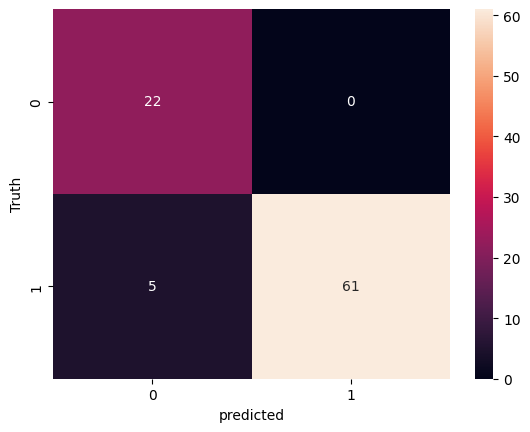

In [337]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

In [328]:
feature_rdkit_gpr6 = pd.Series(model_RF.feature_importances_, index=rdkit_gpr6.columns).sort_values(ascending=False)
feature_rdkit_gpr6.head(10)

FractionCSP3    0.130507
SlogP_VSA6      0.076739
SlogP_VSA3      0.051646
SMR_VSA10       0.046306
SlogP_VSA8      0.043570
EState_VSA2     0.038559
VSA_EState3     0.033569
PEOE_VSA8       0.033160
SMR_VSA5        0.033070
Chi4n           0.027958
dtype: float64

Feature impotance from coefficients

In [338]:
from sklearn.linear_model import RidgeCV

In [339]:
dataset = df_rdkit_desc_standard.values

X = dataset[:, 1:]
y = dataset[:, 0]

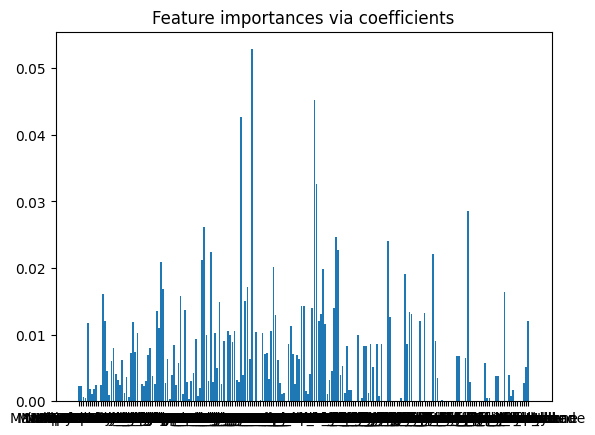

In [341]:
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=10)).fit(x, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(rdkit_gpr6_standardized.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [342]:
from time import time

from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-10] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['SlogP_VSA3' 'SlogP_VSA8' 'NumAliphaticHeterocycles' 'NumAliphaticRings']
Done in 0.067s


In [ ]:
#from sklearn.feature_selection import SequentialFeatureSelector
#
#tic_fwd = time()
#sfs_forward = SequentialFeatureSelector(
#    ridge, n_features_to_select=10, direction="forward"
#).fit(X, y)
#toc_fwd = time()
#
#tic_bwd = time()
#sfs_backward = SequentialFeatureSelector(
#    ridge, n_features_to_select=10, direction="backward"
#).fit(X, y)
#toc_bwd = time()
#
#print(
#    "Features selected by forward sequential selection: "
#    f"{feature_names[sfs_forward.get_support()]}"
#)
#print(f"Done in {toc_fwd - tic_fwd:.3f}s")
#print(
#    "Features selected by backward sequential selection: "
#    f"{feature_names[sfs_backward.get_support()]}"
#)
#print(f"Done in {toc_bwd - tic_bwd:.3f}s")